<a href="https://colab.research.google.com/github/vsophie2002-rgb/swaption_bl/blob/main/NO75BPswaption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp


df = pd.read_excel("/content/swaptionno75copy.xlsx", header=None)


date_col = df.columns[0]
df = df.rename(columns={date_col: "date"})
df["date"] = pd.to_datetime(df["date"], dayfirst=True, errors="coerce")

df = df.dropna(subset=["date"]).reset_index(drop=True)
df = df.dropna(how="all")

headers = ('date', '-200bp', '-100bp', '-50bp', '-25bp', 'ATM', '25bp', '50bp', '100bp' , '200bp' )
df.columns = headers
df["date"] = pd.to_datetime(df["date"], format="%d.%m.%Y")

N_GRID = 800

/tmp/ipython-input-1483608300.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["date"] = pd.to_datetime(df["date"], dayfirst=True, errors="coerce")


In [2]:
rel_bp = np.array([-200, -100, -50, -25, 0, 25, 50, 100, 200], dtype=float)
rel_k = rel_bp/10000.0
vol_cols = [
    "-200bp", "-100bp", "-50bp", "-25bp",
    "ATM",
    "25bp", "50bp", "100bp", "200bp"
]

In [4]:
day_dfs = {}

for i in range(len(df)):
    row = df.iloc[i]
    date_key = pd.to_datetime(row["date"], dayfirst=True).date().isoformat()


    vol = row[vol_cols].to_numpy(dtype=float)


    day_dfs[date_key] = {
        "vol": vol,
        "rel_K": rel_k,

    }

In [5]:
from scipy.stats import norm
import matplotlib.pyplot as plt

In [6]:
def unpack_day(day_dict):

    vol = np.asarray(day_dict["vol"], float)
    rel_K = np.asarray(day_dict["rel_K"], float)

    mask = np.isfinite(rel_K) & np.isfinite(vol)
    return rel_K[mask], vol[mask]

In [7]:
def moments_from_atoms(K_atoms, p):
    K_atoms = np.asarray(K_atoms, float)
    p = np.asarray(p, float)
    p = np.maximum(p, 0.0)
    p = p / p.sum()

    mu = np.sum(p * K_atoms)
    var = np.sum(p * (K_atoms - mu)**2)
    sd = np.sqrt(var) if var > 0 else np.nan

    if np.isfinite(sd) and sd > 0:
        skew = np.sum(p * ((K_atoms - mu)/sd)**3)
        kurt = np.sum(p * ((K_atoms - mu)/sd)**4)
    else:
        skew, kurt = np.nan, np.nan

    return mu, var, skew, kurt

In [8]:
def bachelier_forward_call(K, F, sigma, T):

    K = np.asarray(K, float)
    sigma = np.asarray(sigma, float)

    sT = sigma * np.sqrt(T)
    sT = np.where(sT == 0.0, 1e-16, sT)
    d = (F - K) / sT
    return (F - K) * norm.cdf(d) + sT * norm.pdf(d)

In [9]:
def convex_fit_nodes(K, C, lam=1e-6, enforce_monotone=True, solver="OSQP"):
    """
    Fit adjusted node prices C_hat close to C such that:
      - slopes are nondecreasing (convex in K)
      - slopes <= 0 (monotone decreasing in K), optional
    """
    K = np.asarray(K, float)
    C = np.asarray(C, float)

    m = np.isfinite(K) & np.isfinite(C)
    K, C = K[m], C[m]
    o = np.argsort(K)
    K, C = K[o], C[o]

    n = len(K)
    if n < 5:
        return K, C.copy()

    dK = np.diff(K)
    C_hat = cp.Variable(n)

    slopes = (C_hat[1:] - C_hat[:-1]) / dK          # length n-1
    curv = slopes[1:] - slopes[:-1]                 # length n-2

    constraints = [curv >= 0]                       # convex
    if enforce_monotone:
        constraints += [slopes <= 0]                # decreasing call

    # keep it very close to data; tiny lam just stabilizes if needed
    obj = cp.Minimize(cp.sum_squares(C_hat - C) + lam * cp.sum_squares(curv))
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=getattr(cp, solver), warm_start=True, verbose=False)

    if C_hat.value is None:
        prob.solve(solver=cp.SCS, verbose=False)
        if C_hat.value is None:
            raise RuntimeError("Convex fit failed.")

    return K, np.asarray(C_hat.value).ravel()

In [10]:
def atomic_masses_from_convex_calls(K, C):
    """
    For a piecewise-linear call curve, BL density is atomic:
    masses at interior knots proportional to slope jumps.
    """
    K = np.asarray(K, float)
    C = np.asarray(C, float)

    dK = np.diff(K)
    slopes = (C[1:] - C[:-1]) / dK                  # length n-1

    # slope jumps at interior knots: length n-2
    mass = slopes[1:] - slopes[:-1]
    mass = np.maximum(mass, 0.0)

    total = mass.sum()
    if total > 0:
        mass /= total

    K_atoms = K[1:-1]                               # interior knots
    return K_atoms, mass

In [11]:
def smooth_atomic_pdf(K_atoms, mass, K_eval, bw=0.0025):
    """
    Kernel smooth the atomic masses into a continuous pdf for plotting.
    bw is bandwidth in rate units (0.001 = 10bp).
    """
    K_atoms = np.asarray(K_atoms)[:, None]          # (m,1)
    mass = np.asarray(mass)[:, None]                # (m,1)
    K_eval = np.asarray(K_eval)[None, :]            # (1,N)

    z = (K_eval - K_atoms) / bw
    kernel = np.exp(-0.5 * z**2) / (np.sqrt(2*np.pi) * bw)
    f = (mass * kernel).sum(axis=0)

    # normalize (numerical)
    area = np.trapezoid(f, K_eval.ravel())
    if area > 0:
        f /= area
    return K_eval.ravel(), f


Conditional moments for event centered at t = 2020-03-03


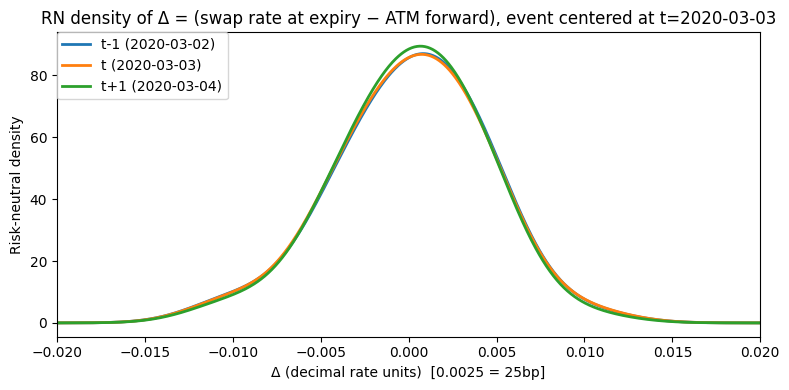

/tmp/ipython-input-2081355530.py:51: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  cell_text = table_df.applymap(lambda x: f"{x:.5g}").values


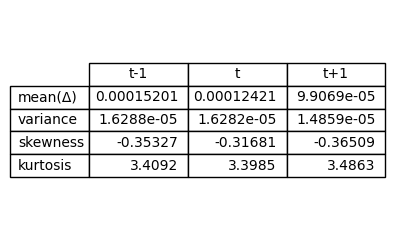


Conditional moments for event centered at t = 2020-03-15


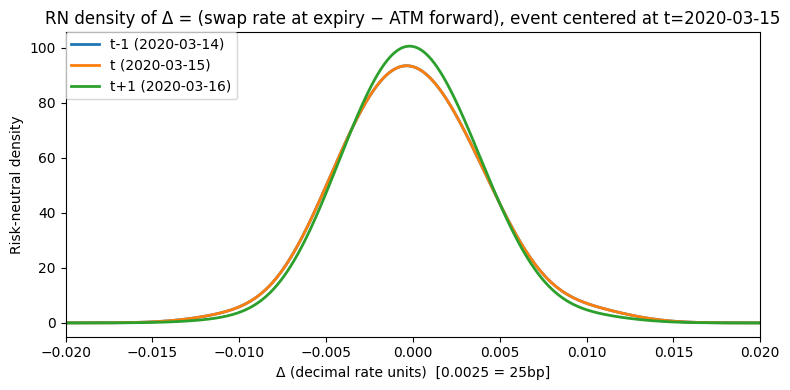

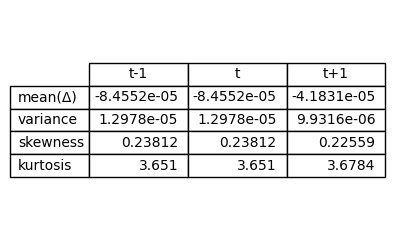


Conditional moments for event centered at t = 2022-03-16


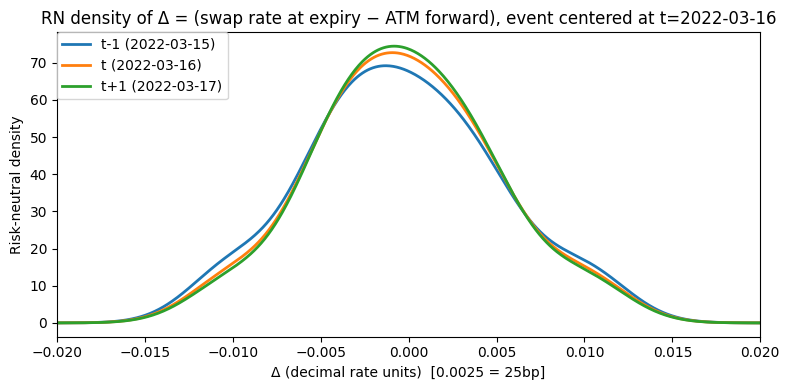

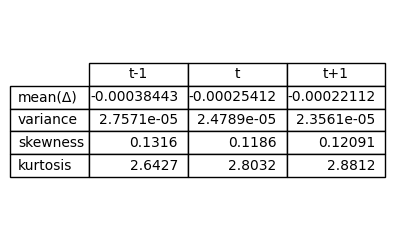


Conditional moments for event centered at t = 2022-06-15


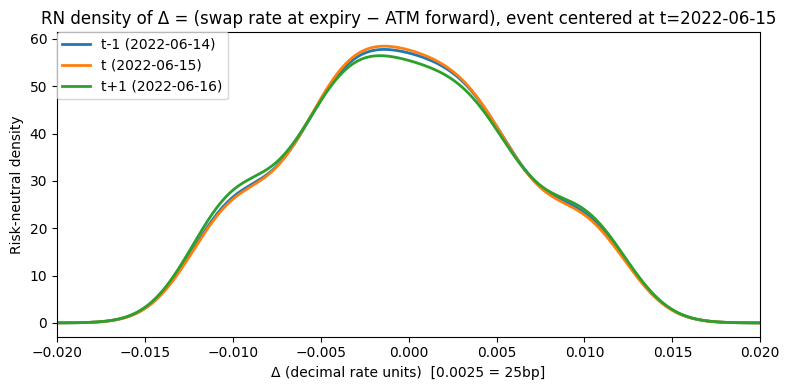

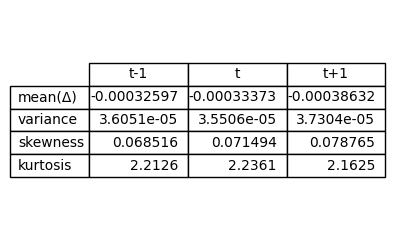


Conditional moments for event centered at t = 2022-07-27


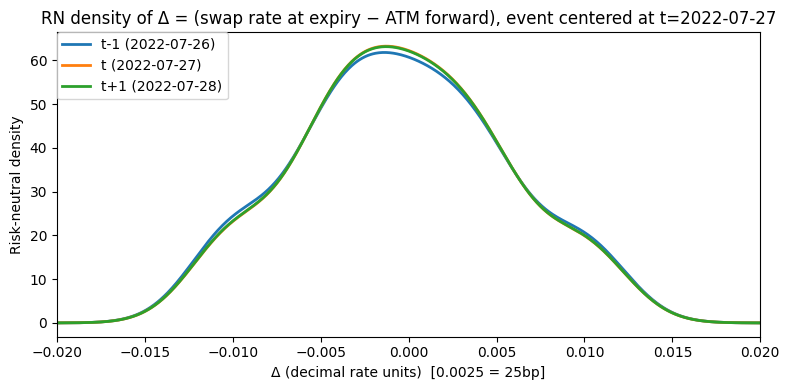

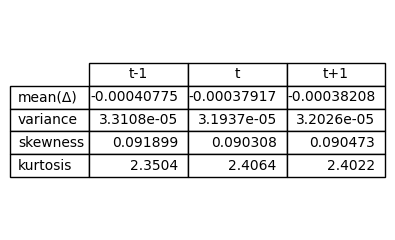


Conditional moments for event centered at t = 2022-09-21


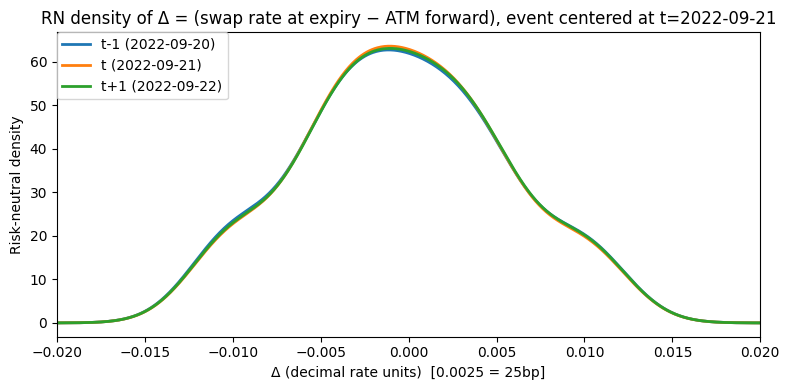

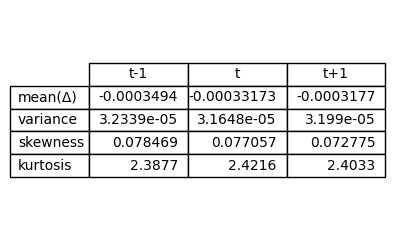

In [17]:
keys = sorted(day_dfs.keys(), key=lambda x: pd.to_datetime(x))

expiry = 0.25
labels = ["t-1", "t", "t+1"]

for i in range(0, len(keys), 3):
    block = keys[i:i+3]
    if len(block) < 3:
        break

    densities = {}
    moments = {}

    # --- build densities + moments for this 3-day block ---
    for k, lab in zip(block, labels):
        relK, vol = unpack_day(day_dfs[k])

        C_fwd = bachelier_forward_call(K=relK, F=0.0, sigma=vol, T=expiry)
        K_nodes, C_fit = convex_fit_nodes(relK, C_fwd, lam=1e-6, enforce_monotone=True)
        K_atoms, mass = atomic_masses_from_convex_calls(K_nodes, C_fit)

        K_eval = np.linspace(relK.min(), relK.max(), N_GRID)
        K_eval, dens = smooth_atomic_pdf(K_atoms, mass, K_eval, bw=0.0025)

        densities[lab] = (K_eval, dens)
        moments[lab] = moments_from_atoms(K_atoms, mass)

    fig_plot, ax_plot = plt.subplots(figsize=(8, 4))

    for lab, k in zip(labels, block):
        K_eval, dens = densities[lab]
        ax_plot.plot(K_eval, dens, linewidth=2, label=f"{lab} ({k})")

    ax_plot.set_title(
        f"RN density of Δ = (swap rate at expiry − ATM forward), event centered at t={block[1]}"
    )
    ax_plot.set_xlabel("Δ (decimal rate units)  [0.0025 = 25bp]")
    ax_plot.set_ylabel("Risk-neutral density")
    ax_plot.set_xlim(-0.02, 0.02)
    ax_plot.legend(loc="upper left", borderaxespad=0)

    fig_plot.tight_layout()
    print(f"\nConditional moments for event centered at t = {block[1]}")
    plt.show()

    table_df = pd.DataFrame(
    {"t-1": moments["t-1"], "t": moments["t"], "t+1": moments["t+1"]},
    index=["mean(Δ)", "variance", "skewness", "kurtosis"]
)

    cell_text = table_df.applymap(lambda x: f"{x:.5g}").values

    fig_table, ax_table = plt.subplots(figsize=(5.5, 2.5))  # adjust size as desired
    ax_table.axis("off")
    mpl_tbl = ax_table.table(
        cellText=cell_text,
        rowLabels=table_df.index,
        colLabels=table_df.columns,
        loc="center"
    )
    mpl_tbl.scale(1.6, 1.2)
    mpl_tbl.auto_set_font_size(False)
    mpl_tbl.set_fontsize(10)

    fig_table.tight_layout()
    plt.show()
